In [102]:
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
import json
import types
import copy
from enum import Enum
import glob
from collections import Counter


In [5]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [6]:
class Sigmoid:
	"""Implementation of the sigmoid function.
	"""
	def activation(self, x):
		return scipy.special.expit(x)

	def derrivative(self, x):
		return x * (1 - x)

class ActivationFunctions(Enum):
	"""Enumeration to keep track of implemented activation 
	functions for initial model validation.
	"""
	sigmoid = Sigmoid()

In [57]:
class AutoEncoder:
	"""Abstract implementation of an autoencoder network.
	"""

	def __init__(self, spec:dict=None, learning_rate:int=0.05):
		if spec:
			if not "input" in [layer["type"] for layer in spec["layers"]]:
				raise ValueError("Models must contain at least one input layer.")
			if not "hidden" in [layer["type"] for layer in spec["layers"]]:
				raise ValueError("Models must contain at least one hidden layer.")
			if not "output" in [layer["type"] for layer in spec["layers"]]:
				raise ValueError("Models must contain at least one output layer.")
			if 0 in [layer["nodes"] for layer in spec["layers"]]:
				raise ValueError("All layers must contain at least one node.")
			if len(list(set([layer["activation_func"] for layer in spec["layers"][1:]]).difference(ActivationFunctions._member_names_))):
				raise NotImplementedError(
					f"One or more specified activation functions are not implemented. Implemented functions include: {', '.join(ActivationFunctions._member_names_)}"
				)

			self.spec = spec
			self.spec["loss"] = []
			self.learning_rate = learning_rate
			
			for i, layer in enumerate(spec["layers"]):
				if layer["type"] != "output":
					next_layer = spec["layers"][i+1]
					self.spec["layers"][i]["weights"] = np.random.normal(
						loc=0.0, 
						scale=pow(next_layer["nodes"], -0.5), 
						size=(next_layer["nodes"], layer["nodes"])
					)
					if self.spec.get("bias", False):
						self.spec["layers"][i]["bias"] = np.random.normal(
							loc=0.0, 
							scale=pow(next_layer["nodes"], -0.5), 
							size=(next_layer["nodes"],1)
						)
			self.model_summary()
	
	def train(self, train_instances:list, test_instances:list, epochs:int=1) -> None:
		"""Trains model using input instances and labels.

		Args:
			train_instances (list): tensor of input instances.
			test_instances (list): tensor of test instances.
			epochs (int, optional): number of epochs for which to
			train the model. Defaults to 1.
		"""
		print("\n".join([
			"========================================",
			"Training Model",
			"========================================",
		]))
		for epoch in range(epochs):
			print(f"Epoch: {epoch}/{epochs}")
			for i, instance in enumerate(train_instances):
				if (((i+1)/len(train_instances)) * 100) % 25 == 0:
					print(f"Progress: {((i+1)/len(train_instances)) * 100}%")
				
				activations = self.forward_pass(instance)
				self.backpropogate(instance, activations)
			
			self.spec["loss"].append(
				self.evaluate(test_instances)
			)

	def forward_pass(self, instance:list) -> list:
		"""Conducts a forward pass through the model,
		generating activations for hidden and output
		layer(s).

		Args:
			instance (list): instance for which to conduct forward 
			pass.

		Returns:
			list: list of dictionaries containing activations
			at each layer.
		"""
		activations = copy.deepcopy(self.spec["layers"])
		for i, layer in enumerate(activations):
			if layer["type"] == "input":
				activations[i]["activations"] = np.array(instance, ndmin=2)
			else:
				activation_func = ActivationFunctions[layer["activation_func"]].value
				bias = activations[i-1].get("bias", 0)
				inputs = np.dot(activations[i-1]["weights"], activations[i-1]["activations"].T) - bias
				activations[i]["activations"] = activation_func.activation(inputs).T
		return activations

	def backpropogate(self, instance:list, activations:list) -> None:
		"""Adjusts model weights through backpropogation.
		Implemented backpropogation assumes sigmoid activation
		functions.

		Args:
			instance (list): instance for which to backpropogate.
			activations (list): list of dictionaries containing activations
			at each layer. Output by self.forward_pass.
		"""
		for i, layer in reversed(list(enumerate(activations))[1:]):
			if layer["type"] == "output":
				activations[i]["errors"] = np.array(instance, ndmin=2).T - layer["activations"].T
			else:
				activations[i]["errors"] = np.dot(layer["weights"].T, activations[i+1]["errors"])

			activation_func = ActivationFunctions[layer["activation_func"]].value
			
			self.spec["layers"][i-1]["weights"] += self.learning_rate * (
				np.dot(
					activations[i]["errors"] * activation_func.derrivative(activations[i]["activations"].T),
					activations[i-1]["activations"]
				)
			)
			if self.spec["bias"]:
				self.spec["layers"][i-1]["bias"] += self.learning_rate * (
					activations[i]["errors"] * activation_func.derrivative(activations[i]["activations"].T) * -1
				)

	def query(self, instance:list) -> None:
		"""Queries the trained model to encode and reconstruct
		an input instance.

		Args:
			instance (list): instance to resconstruct.
		"""
		activations = self.forward_pass(instance)
		reconstructed_instance = activations[-1]["activations"].T

		fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=2, sharey=True, sharex=True)
		for ax, img in zip(axes.flatten(), [instance, reconstructed_instance]):
			ax.xaxis.set_visible(False)
			ax.yaxis.set_visible(False)
			im = ax.imshow(np.array(img, ndmin=2).T.reshape(28,28), cmap = plt.get_cmap("gray"))  
	
		
	def evaluate(self, instances:list) -> float:
		"""Encodes and decodes a set of instances and calculates reconstruction
		errors as mean-squared error of pixel value deviations.

		Args:
			instance (list): instance for which to backpropogate.

		Returns:
			float: average mean-squared error.
		"""
		errors = []
		for instance in instances:
			activations = self.forward_pass(instance)
			prediction = activations[-1]["activations"]
			errors.append((np.square(instance - prediction)).mean(axis=0))

		avg_mse = np.asarray(errors).mean()
		print("Average MSE: {}".format(avg_mse))
		return avg_mse

	def save(self, dir_path:str) -> None:
		"""Writes trained model spec to json.
		
		Args:
			dir_path (str): path to directory in which to save model.
		"""
		with open(f"{dir_path}{self.spec['name']}.json", "w") as f:
			json.dump(self.spec, f, cls=NumpyEncoder)
			print(f"Model saved to {dir_path}{self.spec['name']}.json.")

	def load(self, path_to_spec:str, print_summary:bool=True) -> dict:
		"""Loads in a trained model from json specification file.

		Args:
			path_to_spec (str): path to json specification file.
			print_summary (bool, optional): whether or not to print
			summary of model when it is loaded. Defaults to True.

		Returns:
			dict: trained model specification.
		"""
		with open(path_to_spec) as f:
			spec = json.load(f)
			for i, layer in enumerate(spec["layers"][:-1]):
				spec["layers"][i]["weights"] = np.asarray(spec["layers"][i]["weights"])
			self.spec = spec
			if print_summary:
				self.model_summary()

	def model_summary(self):
		print("\n".join([
			"========================================",
			"Model summary: {}".format(self.spec["name"]),
			"========================================",
			*["{} layer:	{} nodes".format(layer["type"].title(), layer["nodes"]) for layer in self.spec["layers"]],
			"========================================",
		]))

In [8]:
def load_mnist_data(file_path:str, nrows:int=0) -> tuple[list, list]:
	"""Reads in MNIST dataset, aquired from: 
	https://www.kaggle.com/datasets/oddrationale/mnist-in-csv.

	Args:
		file_path (str): file path to the dataset.
		nrows (int, optional): number of rows to read in. 
		Defaults to all rows.

	Returns:
		tuple[list, list]: image instances, and corresponding 
		one-hot encoded labels.
	"""
	if nrows:
		df = pd.read_csv(filepath_or_buffer=file_path, nrows=nrows)
	else: 
		df = pd.read_csv(filepath_or_buffer=file_path)
	x = ((df[df.columns[1:]]/255 * 0.99) + 0.01).to_numpy()
	y = pd.get_dummies(df["label"]).to_numpy()
	return x, y

x_train, y_train = load_mnist_data(
	file_path="data/mnist_train.csv",
)
x_test, y_test = load_mnist_data(
	file_path="data/mnist_test.csv",
	nrows=100,
)

In [ ]:
base_spec = {
	"name": None,
	"layers": [
		{ "type": "input", "nodes": 784 },
		{ "type": "hidden", "nodes": None, "activation_func": "sigmoid" },
		{ "type": "output", "nodes": 784, "activation_func": "sigmoid" },
	],
	"bias": False,
}

for hl in [2, 4, 8, 16, 32, 64, 128]:
	for bias in [True, False]:
		spec = base_spec
		spec["bias"] = bias
		if bias:
			spec["name"] = f"hl_{hl}_bias"
		else:
			spec["name"] = f"hl_{hl}"
		spec["layers"][1]["nodes"] = hl
		model = AutoEncoder(spec, 0.05)
		model.train(
			train_instances=x_train, 
			test_instances=x_test, 
			epochs=50
		)
		model.save(dir_path="./models/")


In [58]:
spec = {
	"name": "hl_2_bias",
	"layers": [
		{ "type": "input", "nodes": 784 },
		{ "type": "hidden", "nodes": 2, "activation_func": "sigmoid" },
		{ "type": "output", "nodes": 784, "activation_func": "sigmoid" },
	],
	"bias": True,
}

model = AutoEncoder(spec, 0.01)
model.train(
	train_instances=x_train, 
	test_instances=x_test, 
	epochs=3
)
model.save(dir_path="./models/scratch/")

Model summary: hl_2_bias
Input layer:	784 nodes
Hidden layer:	2 nodes
Output layer:	784 nodes
Training Model
Epoch: 0/3
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
hl_2_bias average MSE: 0.06519829514010576
Epoch: 1/3
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
hl_2_bias average MSE: 0.06516272561468434
Epoch: 2/3
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
hl_2_bias average MSE: 0.06515441343977668
Model saved to ./models/scratch/hl_2_bias.json.


Loading model from: ./models/hl_16.json ...
Model summary: hl_16
Input layer:	784 nodes
Hidden layer:	16 nodes
Output layer:	784 nodes
Loading model from: ./models/hl_16_bias.json ...
Model summary: hl_16_bias
Input layer:	784 nodes
Hidden layer:	16 nodes
Output layer:	784 nodes


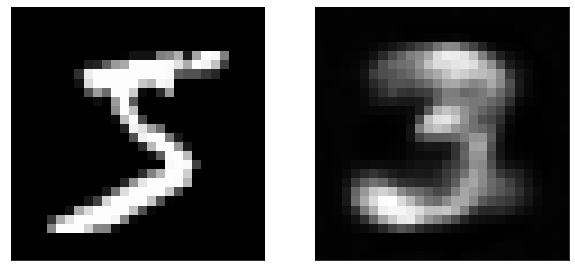

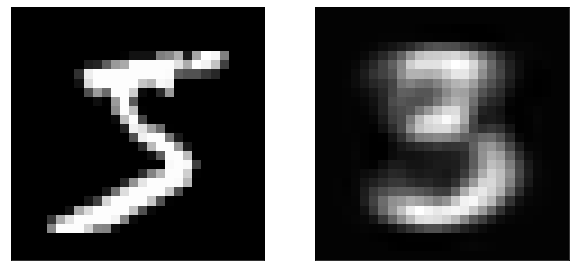

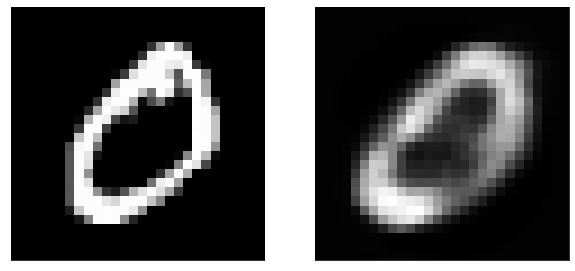

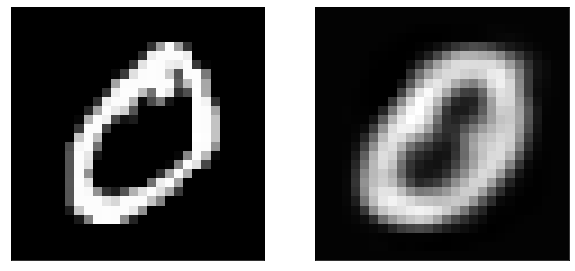

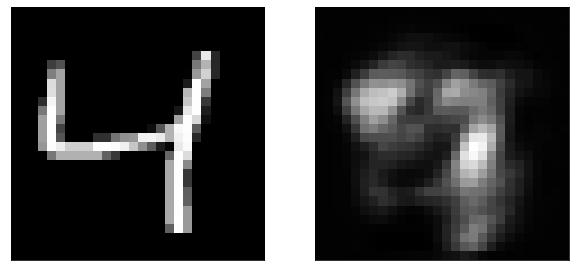

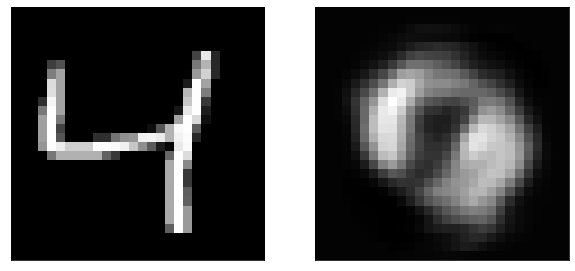

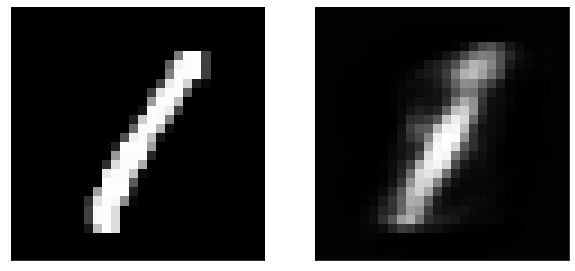

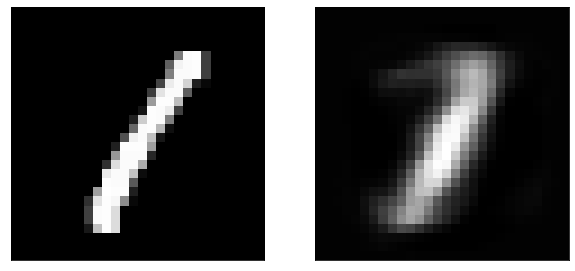

In [46]:
model1 = AutoEncoder()
model1.load("./models/hl_16.json")
model2 = AutoEncoder()
model2.load("./models/hl_16_bias.json")
for i in range(0, 4):
	model1.query(instance=x_train[i])
	model2.query(instance=x_train[i])

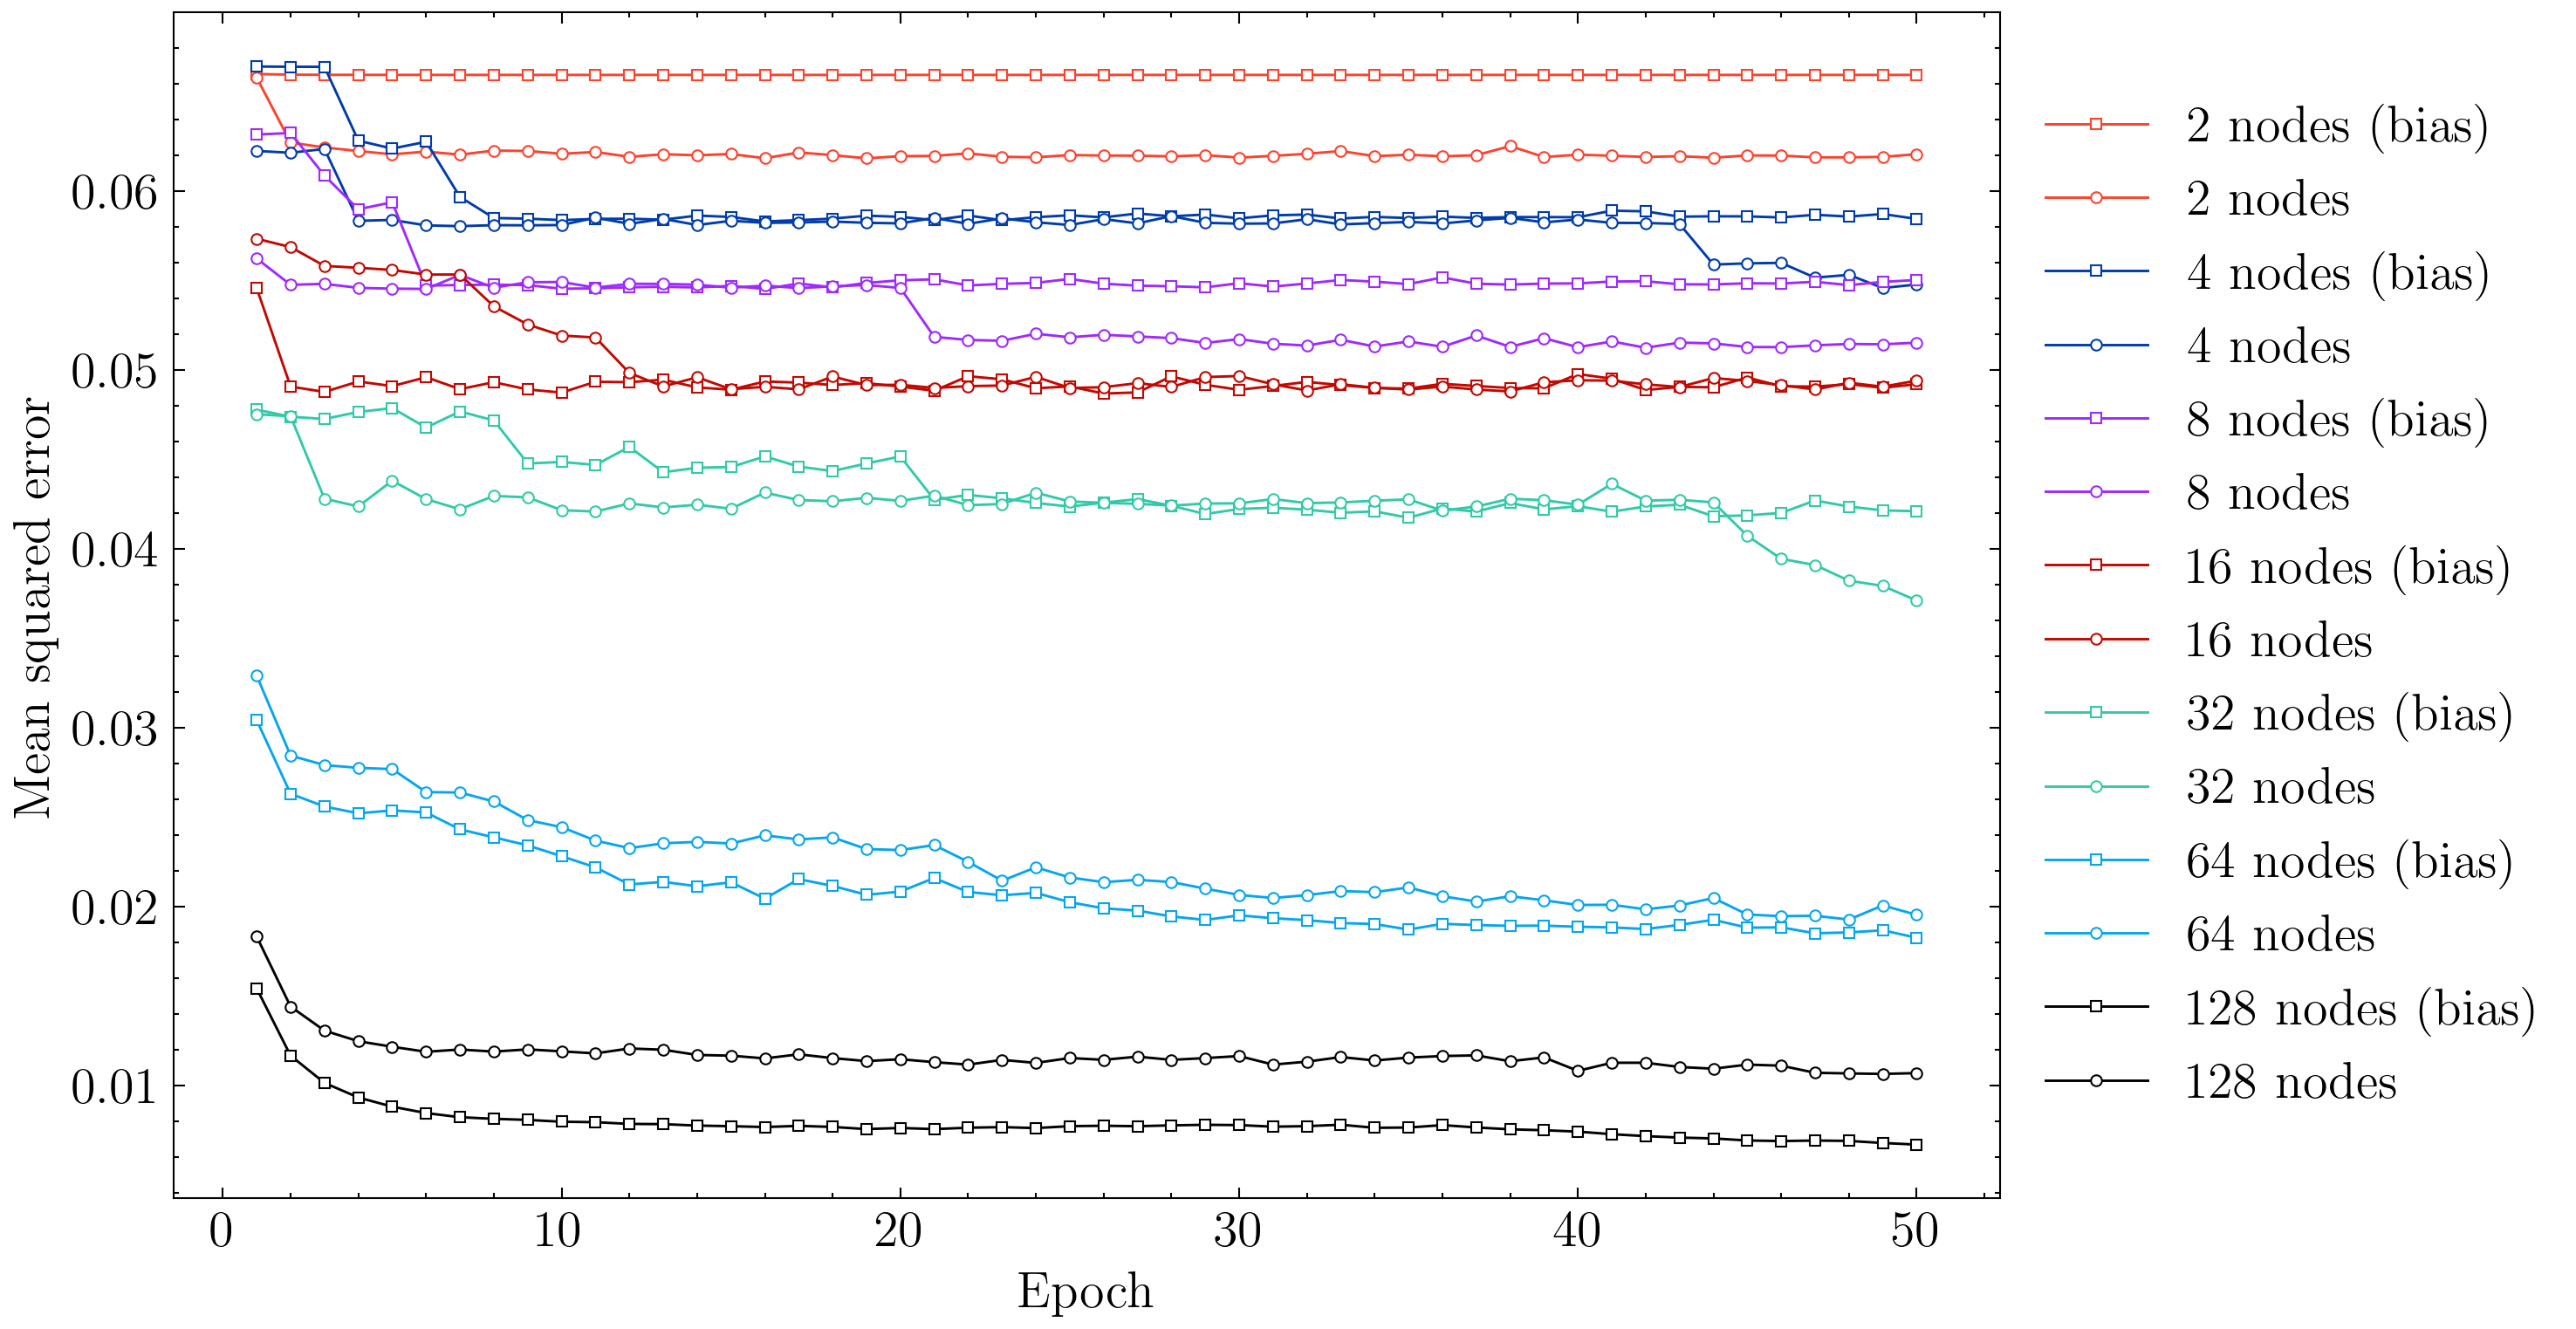

In [163]:
colors = ["#FF412C", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000"]
markers = ["s", "o", "^", "P", "o", "X", "^", "v"]

with plt.style.context("science"):
	plt.figure(figsize=(9,6), dpi=300)
	for hl_i, hl in enumerate([2, 4, 8, 16, 32, 64, 128]):
		for bias_i, bias in enumerate([True, False]):
			if bias:
				model_name = f"hl_{hl}_bias"
				plot_label = f"{hl} nodes (bias)"
			else:
				model_name = f"hl_{hl}"
				plot_label = f"{hl} nodes"
			model = AutoEncoder()
			model.load(
				path_to_spec=f"./models/{model_name}.json",
				print_summary=False,
			)
			mse = model.spec["loss"]
			plt.plot(
				[*range(1, len(mse)+1)], 
				mse,
				color=colors[hl_i],
				marker=markers[bias_i],
				markerfacecolor="#ffffff",
				markersize=3,
				linewidth=0.7,
				markeredgewidth=0.5,
				label=plot_label
			)

	plt.tick_params(labelsize=14)	
	plt.xlabel("Epoch", fontsize=14)
	plt.ylabel("Mean squared error",fontsize=14)
	plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fontsize=14)
	plt.savefig(
		fname=f"../manuscript/graphics/model_loss.pdf",
		dpi=300,
	)
	plt.show()

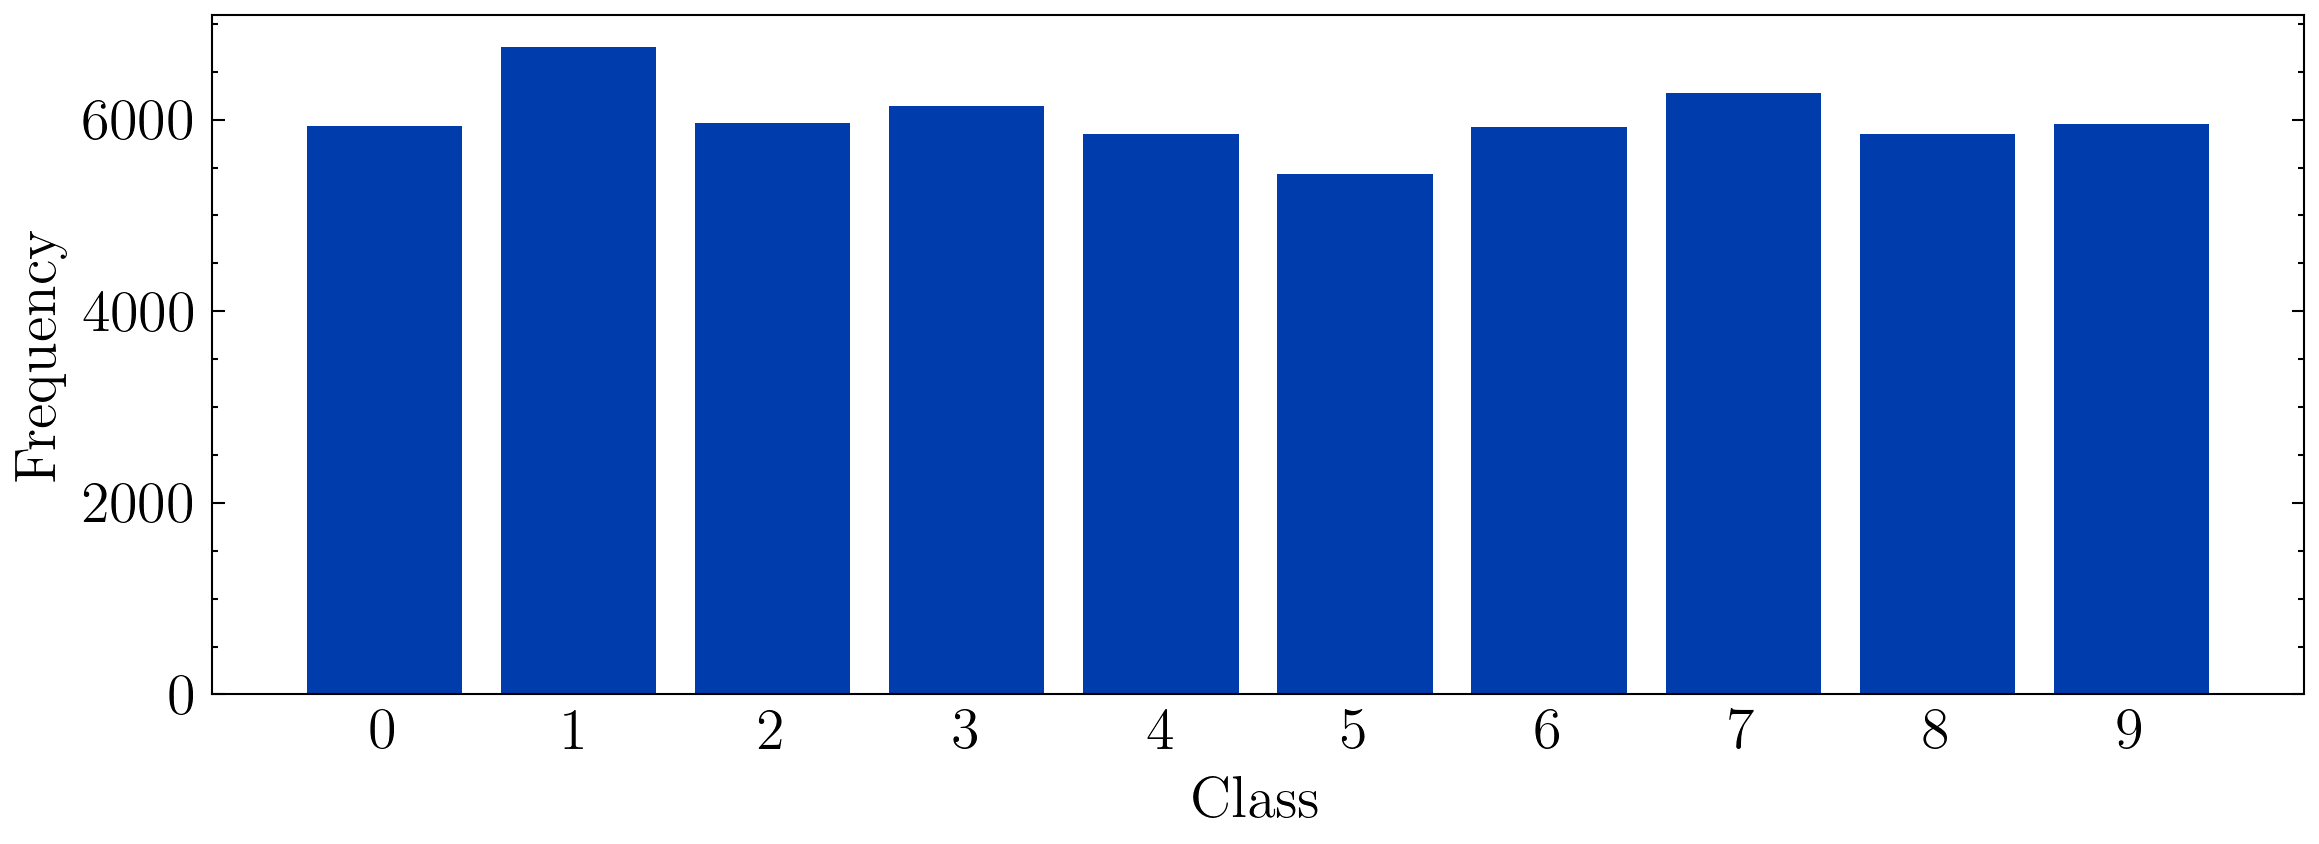

In [161]:
data = [label.index(1) for label in [*y_train.tolist(), *y_test.tolist()]]

with plt.style.context("science"):
	plt.figure(figsize=(9,3), dpi=300)
	plt.xlabel("Class", fontsize=14)
	plt.ylabel("Frequency",fontsize=14)
	plt.bar(Counter(data).keys(), Counter(data).values(), color=colors[1])
	plt.gca().tick_params(axis="x", which="both", length=0)
	plt.tick_params(labelsize=14)	
	plt.xticks(labels=[*range(0,10)], ticks=[*range(0,10)])
	plt.savefig(
		fname=f"../manuscript/graphics/class_distribution.pdf",
		dpi=300,
	)
	plt.show()

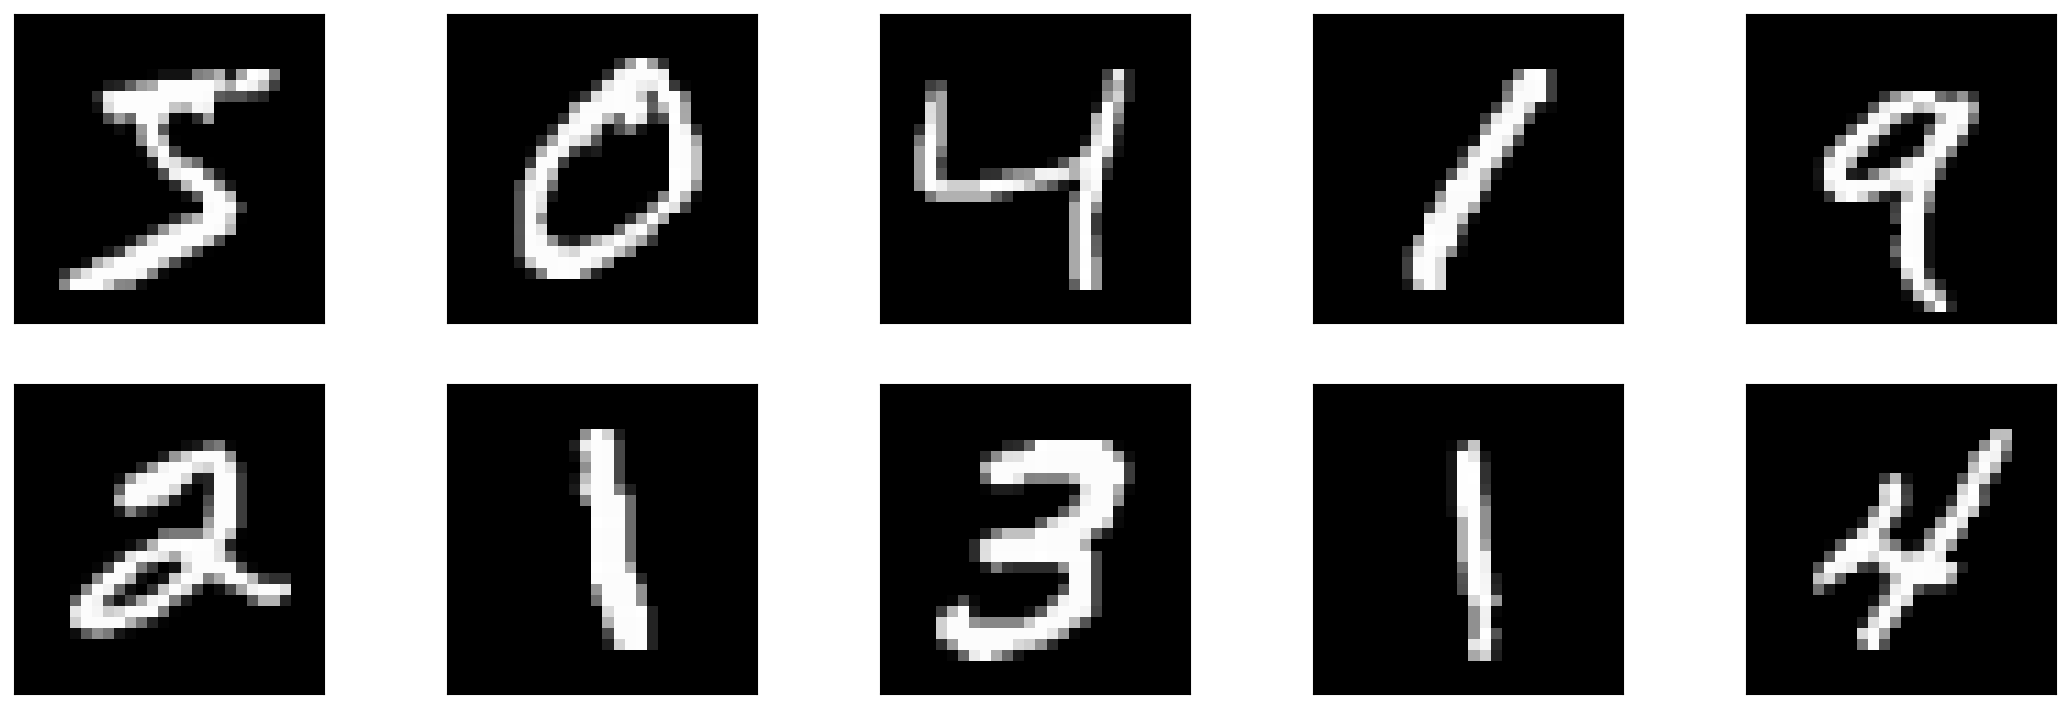

In [158]:
data = x_train[:10]

with plt.style.context("science"):
	fig, axes = plt.subplots(figsize=(9, 3), dpi=300, nrows=2, ncols=5, sharey=True, sharex=True)
	for ax, img in zip(axes.flatten(), data):
		ax.xaxis.set_visible(False)
		ax.yaxis.set_visible(False)
		im = ax.imshow(np.array(img, ndmin=2).T.reshape(28,28), cmap = plt.get_cmap("gray"))  

	plt.savefig(
		fname=f"../manuscript/graphics/instance_examples.pdf",
		dpi=300,
	)
	plt.show()